# Лаб 4. градиентный бустинг

Набор данных - http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

Датасет "Human Activity Recognition Using Smartphones" предназначен для распознавания активности человека с использованием данных, собранных с помощью смартфонов. Основная цель этого набора данных — классифицировать типы активности, которые выполняет человек, используя данные сенсоров, встроенных в смартфон (акселерометр и гироскоп).

Основные характеристики датасета:
* Размер датасета: 10,299 экземпляров (записей).
* Число признаков: 561 характеристика, вычисленная из показаний сенсоров.
* Тип задачи: Многоклассовая классификация.
* Число классов (меток активности): 6 классов.
  * WALKING: Ходьба.
  * WALKING_UPSTAIRS: Подъем по лестнице.
  * WALKING_DOWNSTAIRS: Спуск по лестнице.
  * SITTING: Сидение.
  * STANDING: Стояние.
  * LAYING: Лежание.
* Тип данных: Числовые (результаты измерений с сенсоров).
* Используемое оборудование: Смартфон Samsung Galaxy S II, который регистрировал данные через встроенные акселерометр и гироскоп.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt

from typing import Type
from dataclasses import dataclass
import sys

In [3]:
path = '/content/drive/MyDrive/6 сем/обработка данных/Лаб 4/UCI HAR Dataset'

with open(f'{path}/train/X_train.txt') as f:
    X = np.array(list(map(lambda el: list(map(float, el.split())), f.read().split('\n')))[:-1])

with open(f'{path}/train/y_train.txt') as f:
    y = np.array(f.read().split(), dtype=int) - 1

In [4]:
df = pd.DataFrame(X)
df['target'] = y

In [5]:
df

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,target
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,4
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,4
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,4
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,4
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,1
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,1
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,1
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,1


In [18]:
df.columns[:-1]

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       551, 552, 553, 554, 555, 556, 557, 558, 559, 560],
      dtype='object', length=561)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
class DecisionTreeRegressor:
    def __init__(self, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.tree = self._build_tree(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_single(x, self.tree) for x in X])

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0) -> dict:
        n_samples, n_features = X.shape
        unique_y = np.unique(y)

        # Проверка остановки
        if (n_samples < self.min_samples_split or
                len(unique_y) == 1 or
                (self.max_depth is not None and depth >= self.max_depth)):
            return np.mean(y)

        # Находим лучший разрез
        best_split = self._find_best_split(X, y, n_samples, n_features)
        if best_split is None:
            return np.mean(y)

        left_indices = X[:, best_split['feature']] < best_split['threshold']
        right_indices = X[:, best_split['feature']] >= best_split['threshold']

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _find_best_split(self, X: np.ndarray, y: np.ndarray, n_samples: int, n_features: int) -> dict:
        best_split = None
        best_score = float('inf')

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                # Проверка минимальных образцов
                if (len(y[left_indices]) < self.min_samples_leaf or
                        len(y[right_indices]) < self.min_samples_leaf):
                    continue

                score = self._calculate_mse(y[left_indices], y[right_indices])
                if score < best_score:
                    best_score = score
                    best_split = {'feature': feature, 'threshold': threshold}

        return best_split

    def _calculate_mse(self, left_y: np.ndarray, right_y: np.ndarray) -> float:
        left_mean = np.mean(left_y) if len(left_y) > 0 else 0
        right_mean = np.mean(right_y) if len(right_y) > 0 else 0

        left_mse = np.sum((left_y - left_mean) ** 2)
        right_mse = np.sum((right_y - right_mean) ** 2)

        return (left_mse + right_mse) / (len(left_y) + len(right_y))

    def _predict_single(self, x: np.ndarray, tree: dict) -> float:
        if isinstance(tree, dict):
            if x[tree['feature']] < tree['threshold']:
                return self._predict_single(x, tree['left'])
            else:
                return self._predict_single(x, tree['right'])
        else:
            return tree


In [8]:
from sklearn.tree import DecisionTreeRegressor

Определять вероятности принадлежности к какому-либо классу будет one-vs-all модель. Для каждого класса строится своя модель, которая предсказывает вероятность того, что данный объект принадлежит именно этому классу.

In [9]:
class ActivityClassifier():
    def __init__(self, max_depth):
        self.regressors = []
        self.max_depth=max_depth
    def fit(self, X: np.ndarray, y: np.ndarray, y_one_hot: bool) -> None:
        if not y_one_hot:
            y = np.eye(np.unique(y).shape[0])[y]
        self.regressors = [DecisionTreeRegressor(max_depth=3) for i in range(y.shape[1])]
        for i in range(y.shape[1]):
            self.regressors[i].fit(X, y[:, i])

    def predict(self, X: np.ndarray, y_one_hot: bool) -> np.ndarray:
        out = np.zeros(X.shape[0])
        y = self.predict_proba(X)
        if y_one_hot:
            for i,_ in enumerate(y):
                max_ = np.argmax(y[i])
                y[i] = 0
                y[i, max_] = 1
            return y

        for i,_ in enumerate(y):
            out[i] = np.argmax(y[i])
        return out

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        y = np.zeros([X.shape[0], len(self.regressors)])
        for i, reg in enumerate(self.regressors):
            y[:, i] = reg.predict(X)

        return y

In [10]:
class GradientBooster():
    def __init__(self, Classifier_, alpha=0.1, n_estimators=100, **Classifier_params):
        self.Classifier = Classifier_
        self.alpha = alpha #learning rate
        self.n_estimators = n_estimators #количество деревьев
        self.Classifier_params = Classifier_params
        self.trees = [] #сохраняем деревья

    def fit(self, X: np.ndarray, y: np.ndarray, y_one_hot=False) -> None:
        if not y_one_hot:
            y = np.eye(np.unique(y).shape[0])[y]  # Преобразование меток в one-hot

        # Инициализируем первый классификатор
        self.trees.append(self.Classifier(**self.Classifier_params))
        self.trees[0].fit(X, y, y_one_hot=True)
        out = self.trees[0].predict_proba(X)

        # Обучаем остальные классификаторы
        for _ in tqdm(range(1, self.n_estimators)):

            # градиент функции потерь многоклассовой классификации
            # grad = softmax - y
            # дает разницу между предсказанными вероятностями и истинными метками
            grad = np.exp(out) / np.sum(np.exp(out), axis=1, keepdims=True) - y
            new_model = self.Classifier(**self.Classifier_params)
            new_model.fit(X, grad, y_one_hot=True)
            self.trees.append(new_model)
            out -= self.alpha * new_model.predict_proba(X)

    def predict(self, X: np.ndarray) -> np.ndarray:
        out = self.trees[0].predict(X, y_one_hot=True)
        for tree in self.trees[1:]:
            out -= self.alpha * tree.predict(X, y_one_hot=True)
        return np.argmax(out, axis=1)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        out = self.trees[0].predict(X, y_one_hot=True)
        for tree in self.trees[1:]:
            out -= self.alpha * tree.predict(X, y_one_hot=True)
        return np.exp(out) / np.sum(np.exp(out), axis=1, keepdims=True)


In [11]:
my_booster = GradientBooster(ActivityClassifier, n_estimators=100, max_depth=3)

In [12]:
my_booster.fit(X_train, y_train)

100%|██████████| 99/99 [14:52<00:00,  9.01s/it]


In [15]:
from sklearn.tree import plot_tree

[Text(0.5, 0.875, '166 <= -0.571\nsquared_error = 0.139\nsamples = 5881\nvalue = 0.166'),
 Text(0.25, 0.625, '247 <= 0.861\nsquared_error = 0.018\nsamples = 3879\nvalue = 0.019'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, '357 <= -0.276\nsquared_error = 0.006\nsamples = 3724\nvalue = 0.006'),
 Text(0.0625, 0.125, 'squared_error = 0.005\nsamples = 3714\nvalue = 0.005'),
 Text(0.1875, 0.125, 'squared_error = 0.24\nsamples = 10\nvalue = 0.4'),
 Text(0.375, 0.375, '222 <= -0.212\nsquared_error = 0.221\nsamples = 155\nvalue = 0.329'),
 Text(0.3125, 0.125, 'squared_error = 0.037\nsamples = 105\nvalue = 0.038'),
 Text(0.4375, 0.125, 'squared_error = 0.056\nsamples = 50\nvalue = 0.94'),
 Text(0.75, 0.625, '503 <= -0.338\nsquared_error = 0.248\nsamples = 2002\nvalue = 0.453'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, '69 <= -0.364\nsquared_error = 0.154\nsamples = 1011\nvalue = 0.809'),
 Text(0.5625, 0.125, 'squared_error = 0.188\nsamples = 188\nvalue = 0.25'),
 Text(0.6875, 0

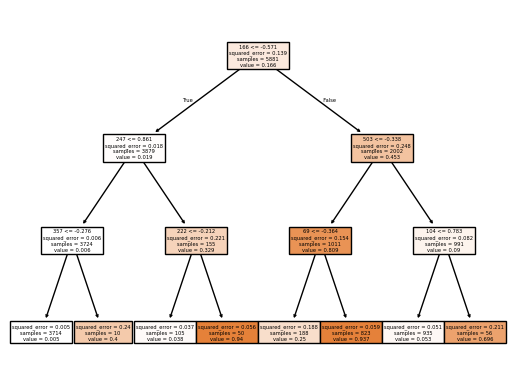

In [31]:
plot_tree(my_booster.trees[0].regressors[0], filled=True, feature_names=df.columns[:-1], class_names=df['target'])

In [32]:
!pip install graphviz

In [37]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(my_booster.trees[0].regressors[1], out_file=None,
                           feature_names=df.columns[:-1],
                           class_names=df['target'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph.view()

'decision_tree.pdf'

In [26]:
df.columns[-1]

'target'

In [19]:
df.columns[-1]

'target'

In [13]:
predicts = my_booster.predict(X_test)
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, predicts)

Accuracy: 0.9014276002719238
Precision on class 0: 0.9011857707509882
Recall on class 0: 0.9230769230769231
F1-score on class 0: 0.912




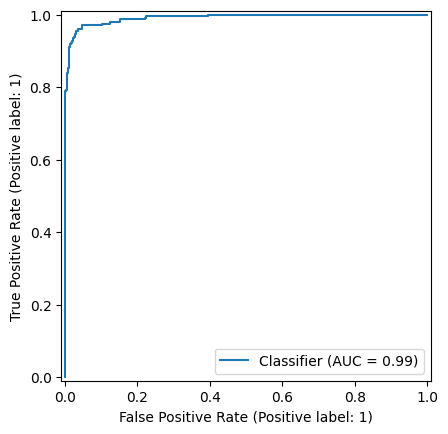

Precision on class 1: 0.9322916666666666
Recall on class 1: 0.895
F1-score on class 1: 0.9132653061224489




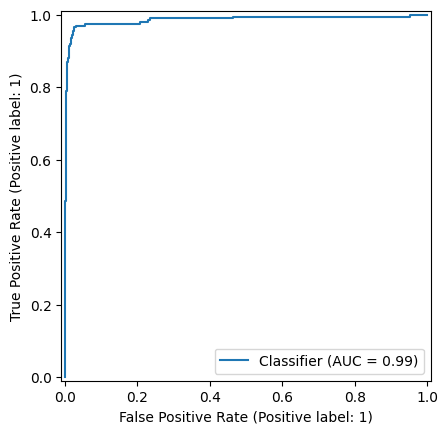

Precision on class 2: 0.9035532994923858
Recall on class 2: 0.8640776699029126
F1-score on class 2: 0.8833746898263027




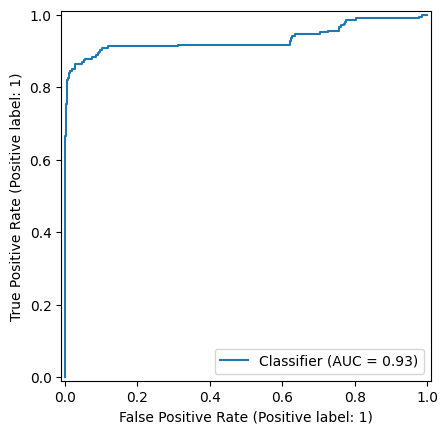

Precision on class 3: 0.7927631578947368
Recall on class 3: 0.9198473282442748
F1-score on class 3: 0.8515901060070671




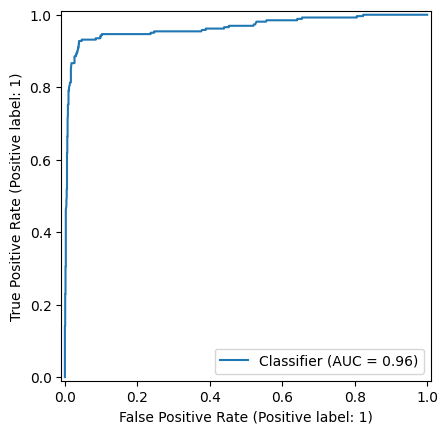

Precision on class 4: 0.9243697478991597
Recall on class 4: 0.7971014492753623
F1-score on class 4: 0.8560311284046692




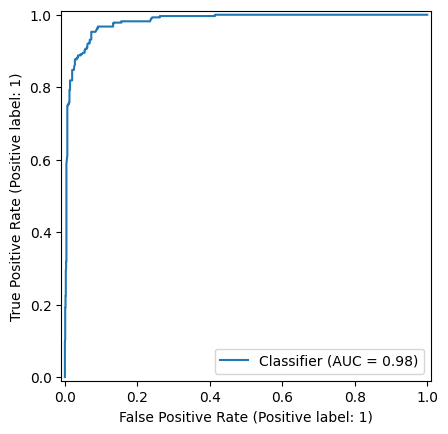

Precision on class 5: 0.975609756097561
Recall on class 5: 1.0
F1-score on class 5: 0.9876543209876543




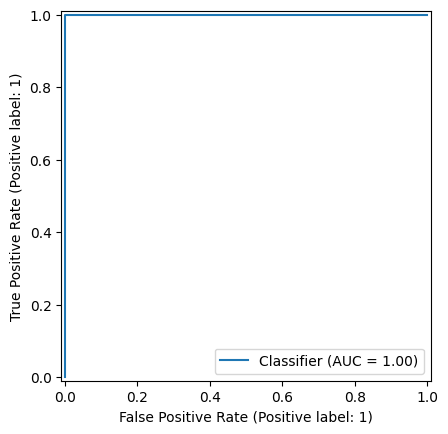

In [14]:
print('Accuracy:', accuracy_score(y_test, predicts))
for i,_ in enumerate(precision):
    print(f'Precision on class {i}: {precision[i]}')
    print(f'Recall on class {i}: {recall[i]}')
    print(f'F1-score on class {i}: {f_score[i]}')
    print('\n')
    probas = my_booster.predict_proba(X_test)
    RocCurveDisplay.from_predictions(np.eye(np.unique(y_test).shape[0])[y_test][:,i], probas[:,i])
    plt.show()